In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import mne
import numpy as np
from pathlib import Path
from no_wander.process import get_files_by_session, load_session_data

mne.set_log_level('WARNING')

In [3]:
DATA_DIR = Path.cwd().parent / 'data' / 'processed'
FILE_GLOB = "*.EEG.*.csv"
SAMPLE_SIZE_SEC = 7

In [4]:
session_files = get_files_by_session(DATA_DIR, FILE_GLOB)

In [6]:
raws = []
mne_info = None
for files in list(session_files.values())[:100]:
    _, data = load_session_data(files, aux_channel=None, rename=False)
    if mne_info is None:
        mne_info = mne.create_info(
            ch_names=[col.replace('EEG_', '') for col in data.columns],
            ch_types=['eeg'] * (len(data.columns) - 1) + ['stim'],
            sfreq=256,
        )
    data = data.values.T
    data[:-1, :] *= 1e-6
    data[-1, data[-1, :] != 1] = 0
    
    raw = mne.io.RawArray(data=data, info=mne_info)
    raw.set_eeg_reference(projection=True).apply_proj()
    raw.filter(l_freq=1, h_freq=45, picks=['eeg'])
    raw.set_montage("standard_1005")
    raws.append(raw)
    
    del data

raw = mne.concatenate_raws(raws)

In [42]:
def get_epochs(raw, events, tmin=0, tmax=0):
    event_id = {'recovery': 1}
    epochs = mne.Epochs(
        raw,
        events,
        baseline=None,
        event_id=event_id,
        picks=mne.pick_types(raw.info, eeg=True, exclude='bads'),
        proj=False,
        reject={'eeg': 5e-5},
        tmax=tmax,
        tmin=tmin,
    )
    epochs.drop_bad()
    print(epochs)
    return epochs

events = mne.find_events(raw)
epochs_pre = get_epochs(raw, events, tmin=-SAMPLE_SIZE_SEC)
epochs_post = get_epochs(raw, events, tmax=SAMPLE_SIZE_SEC)

<Epochs  |   117 events (all good), -7 - 0 sec, baseline off, ~20 kB, data not loaded,
 'recovery': 117>
<Epochs  |   115 events (all good), 0 - 7 sec, baseline off, ~20 kB, data not loaded,
 'recovery': 115>


Pre-Recovery


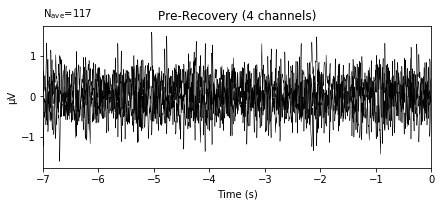

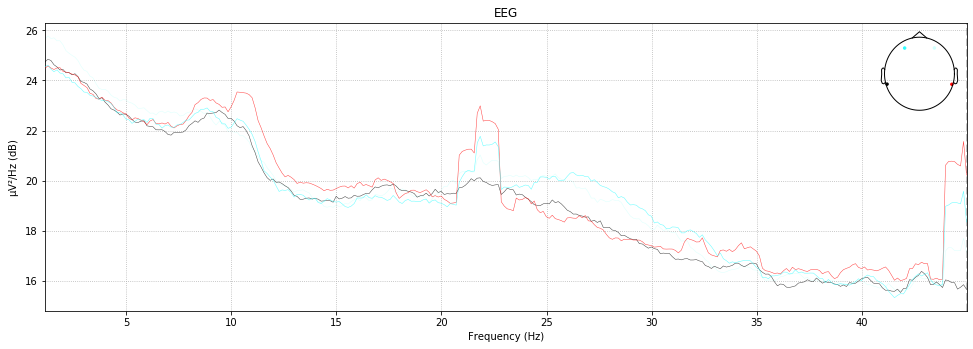

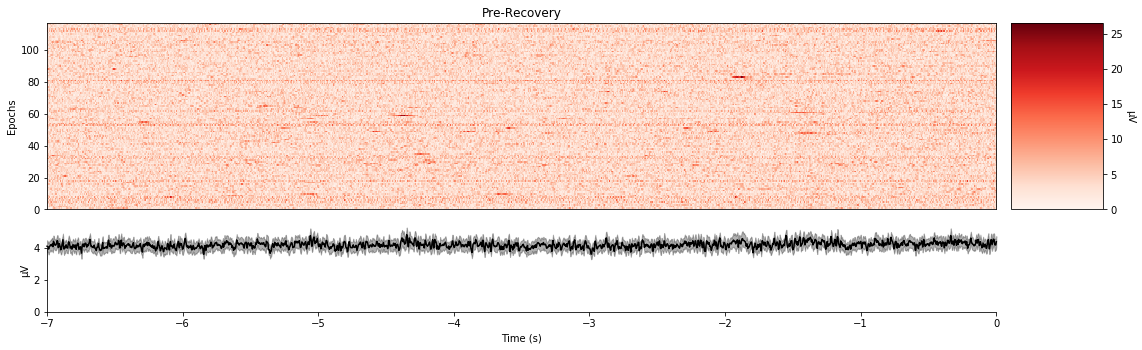

Post-Recovery


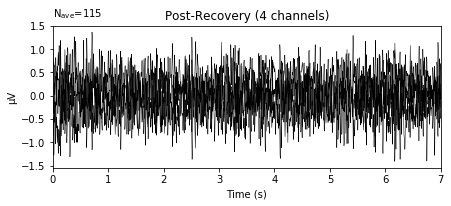

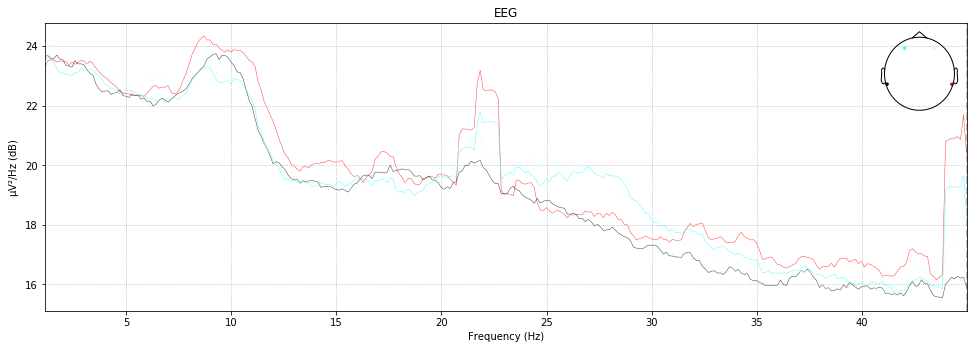

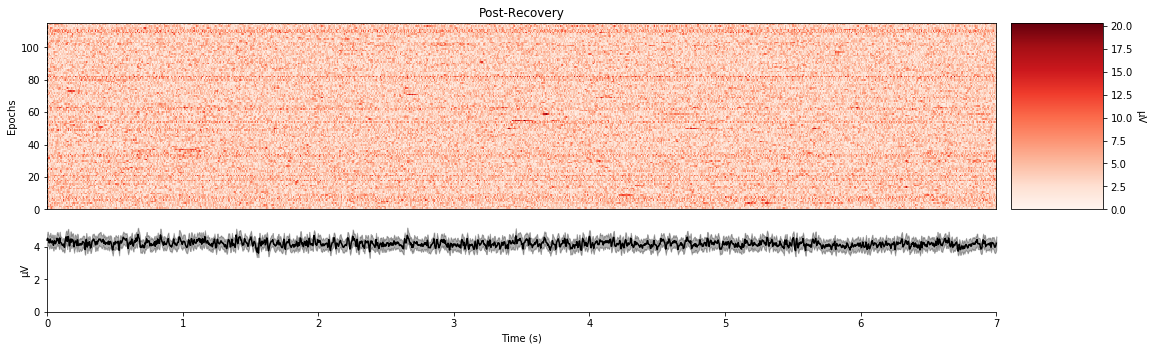

In [48]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 5]

for epoch_type, epochs in [('Pre', epochs_pre), ('Post', epochs_post)]:
    title = f"{epoch_type}-Recovery"
    print(title)
    epochs.average().plot(titles=dict(eeg=title))
    epochs.plot_psd(1, 45, spatial_colors=True, average=False)
    mne.viz.plot_epochs_image(epochs, title=title)

* Bands over time
  * Mu waves (7.2 - 12.5, primarily 9 - 11): These waves are located over the motor cortex and are primarily associated with a state of physical rest. They are desynchronixed (a.k.a. suppressed) during a motor action.
* Topomap with bandpass filters
* Wavelet transform unsupervised
* ICA/SSP then dipole
* PCA
* N2pc ERP

# Performance Baseline: Simple Models
Attempt SVM for baseline